In [1]:
%%latex
3. EM algorithm and implementation
(a) The parameters of Gaussian Mixture Model (GMM) can be estimated via the EM algorithm. 
Show that the alternating algorithm for k-means (in Lec. 11) is a special case of the EM algorithm 
and show the corresponding objective functions for E-step and M-step.

e-step:
$$ r_ic = \left\{
\begin{aligned}
0  \ if \ min(\mu-i) != \mu_c - i \\
1  \ if \ min(\mu-i) = \mu_c - i \\
\end{aligned}
\right.
$$

m-step:
$$
\mu_c = \frac{\sum r_ic * i}{\sum r_ic}
$$ 

<IPython.core.display.Latex object>

In [2]:
%%latex

(b) Download the Old Faithful Geyser Dataset. The data file contains 272 observations of (eruption time, waiting time). 
Treat each entry as a 2 dimensional feature vector. Parse and plot all data points on 2-D plane.

<IPython.core.display.Latex object>

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

df = pd.read_csv('faithful.txt', header = 0, delimiter = '\s+')
data = df.values
data.shape

(272L, 2L)

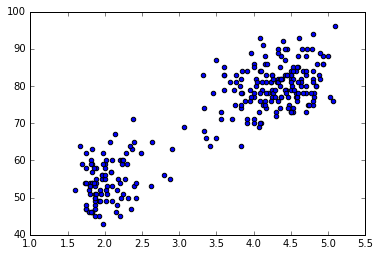

In [59]:
feature1 = data[:,0]
feature2 = data[:,1]

plt.scatter(feature1, feature2)

In [8]:
%%latex

(c) Implement a bimodal GMM model to fit all data points using EM algorithm.
Explain the reasoning behind your termination criteria. For this problem, we assume the covariance matrix is spherical 
and you can randomly initialize Gaussian parameters. 

For evaluation purposes, please submit the following figures: 
• Plot the trajectories of two mean vectors in 2 dimensions (i.e.,coordinates vs. iteration). 
• Run your program for 50 times with different initial parameter guesses.  
Show the distribution of the total number of iterations needed for algorithm to converge.

<IPython.core.display.Latex object>

In [61]:
# at first we scale the data to 0~1
from sklearn.preprocessing import MinMaxScaler
data = df
scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)
data_scaled.head()

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453


In [64]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
 
k = 2
class GMM_EM:
    
    def __init__(self, k, data, threshold=10e-4):
        self.k = k
        self.data = data
        self.num_data, self.num_features = self.data.shape
        self.threshold = threshold
    
    def __get_init_params(self):
        #set mu[mu1, mu2]
        mu = np.random.rand(self.k, self.num_features)
        #set cov-matrix
        cov_rand = np.random.rand(self.k)
        cov = []
        for rand in cov_rand:
            cov.append(np.diag([rand, rand]))
        cov = np.array(cov)
        #set pi, as k = 2, just simplify the process
        pi = []
        remain = 1
        pi_rand = np.random.rand(self.k-1)
        for rand in pi_rand:
            pi.append(rand)
            remain -= rand * remain
        pi.append(remain)
        pi = np.array(pi)
        return mu, cov, pi


    # EM, step 1, calculate the E[zij]
    def e_step(self, mu, cov, pi):
        # Calculate probabilities for all samples to each model
        prob = np.zeros((self.num_data, self.k))
        for k in range(self.k):
            prob[:, k] = multivariate_normal.pdf(self.data, mean=mu[k], cov=cov[k])

        # Calculate responsibility for each model to every sample
        responsibility = np.zeros((self.num_data, self.k))
        for k in range(self.k):
            responsibility[:, k] = pi[k] * prob[:, k]
        for i in range(self.num_data):
            Sum = np.sum(responsibility[i, :])
            if Sum != 0:
                responsibility[i, :] /= Sum
        return responsibility

    # EM, step 2, maximum E[zij]
    def m_step(self, responsibility):
        mu = np.zeros((self.k, self.num_features))
        cov = []
        pi = np.zeros(self.k)
        
        #calculate the new_mu and new_cov
        for k in range(self.k):
            # sum of responses of all samples for kth model
            sum_resp = np.sum(responsibility[:, k])
            for f in range(self.num_features):
                mu[k, f] = np.sum(np.multiply(responsibility[:, k], self.data[:, f])) / sum_resp

                # cov (spherical)
                cov_k = 0
                for i in range(self.num_data):
                    cov_k += responsibility[i, k] * np.sum(np.square(self.data[i] - mu[k]))
                cov_k /= sum_resp
                cov.append(np.diag([cov_k, cov_k]))

                # pi
                pi[k] = sum_resp / self.num_data
        return mu, cov, pi
    
    def __append_mu(self, mus, mu):
        for i in range(self.k):
            for j in range(self.num_features):
                mus[i][j].append(mu[i][j])
                
    # this will iterate iter_num，or stopiteration when approaching - Epsilon
    def run(self, init_mu=None, init_cov=None):
        mu, cov, pi = self.__get_init_params()
        
        if init_mu is not None:
            mu = init_mu
        if init_cov is not None:
            cov = init_cov
        
        mus = [ [ [] for _ in range(self.num_features) ] for __ in range(self.k) ]
        self.__append_mu(mus, mu)
        iterations = 0
        log_likelyhoods = []
        while iterations < 100:
            resp = self.e_step(mu, cov, pi)
            mu, cov, pi = self.m_step(resp)
            self.__append_mu(mus, mu)
            iterations += 1
            
            log_likelyhood = np.zeros(self.num_data)
            for k in range(self.k):
                log_likelyhood += multivariate_normal.pdf(self.data, mean=mu[k], cov=cov[k]) * pi[k]
            
            log_likelyhood = np.sum(np.log10(log_likelyhood))
            log_likelyhoods.append(log_likelyhood)
            
            
            if iterations>5 and abs(log_likelyhoods[-1]-log_likelyhoods[-2]) / abs(log_likelyhoods[-1]) < self.threshold:
                break
        return mus, iterations
        
print 'end'

end


('Done with', 11, 'iterations.')


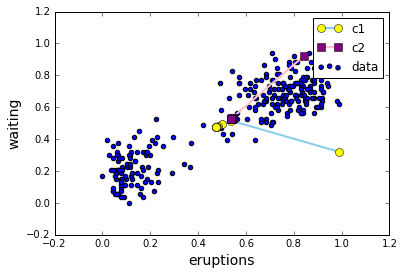

In [75]:
model = GMM_EM(2, data_scaled.values)
mus, iters = model.run()

print("Done with", iters, "iterations.")

mus1 = pd.DataFrame({data.columns[0]: mus[0][0], data.columns[1]: mus[0][1]})
mus2 = pd.DataFrame({data.columns[0]: mus[1][0], data.columns[1]: mus[1][1]})

plt.figure()
plt.scatter(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], label="data", alpha=1)
plt.xlabel(data.columns[0], fontsize=14)
plt.ylabel(data.columns[1], fontsize=14)
plt.plot(data.columns[0], data.columns[1], data=mus1, label='c1', marker='o', markerfacecolor='yellow', markersize=8, color='skyblue', linewidth=2)
plt.plot(data.columns[0], data.columns[1], data=mus2, label='c2', marker='s', markerfacecolor='purple', markersize=8, color='pink', linewidth=2)
plt.legend()

In [47]:
log_likelyhoods

NameError: name 'log_likelyhoods' is not defined

In [45]:
print 'start'
model = GMM_EM(2, data_scaled)
mus, iters = model.run()
print iters
print 'end'

mus1 = pd.DataFrame({'data1': mus[0][0], 'data2': mus[0][1]}).values
mus2 = pd.DataFrame({'data1': mus[1][0], 'data2': mus[1][1]}).values

plt.figure()
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], label="data", alpha=1)
plt.plot(mus1[:,0], mus1[:,1], label='c1', marker='o', color='blue')
plt.plot(mus2[:,0], mus2[:,1], label='c2', marker='o', color='pink')
plt.show()

start


UnboundLocalError: local variable 'remain' referenced before assignment

In [496]:
interationNum = []
model = GMM_EM(2, data_scaled)
for _ in range(50):
    mus, iters = model.run()
    interationNum.append(iters)
print 'end'

end


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 3., 2., 1., 0., 0., 3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 27 Patch objects>)

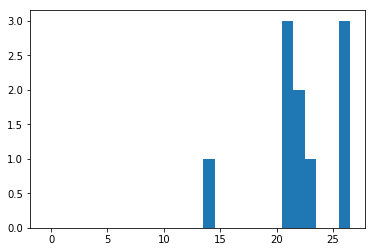

In [521]:
plt.hist(interationNum, bins=range(max(interationNum) + 1), align='left', rwidth=1)

In [548]:
%%latex

(d) Repeat the task in (c) but with the initial guesses of the parameters generated from the fol- lowing process:
• Run a k-means algorithm over all the data points with K = 2 and label each point with one of the two clusters.
• Estimate the first guess of the mean and covariance matrices using maximum likelihood over the labeled data points.
Compare the algorithm performances of (c) and (d).

<IPython.core.display.Latex object>

In [509]:
def runKmeans(show=False):
    kmeans = KMeans(n_clusters=2, random_state=50).fit(data_scaled)
    pred = kmeans.predict(data_scaled)
    
    c1 = data_scaled[pred==0]
    c2 = data_scaled[pred==1]
    
    if show == True:

        mu = kmeans.cluster_centers_
        cov = [np.cov(c1), np.cov(c2)]
        plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=pred)
    
    return mu, cov

end


(array([[0.77095402, 0.69908913],
        [0.12818076, 0.21967655]]),
 [array([[ 5.81222165e-03,  4.83896513e-03, -2.45537304e-03, ...,
          -1.16535044e-04,  4.41699784e-03, -1.26273421e-02],
         [ 4.83896513e-03,  4.02868042e-03, -2.04422082e-03, ...,
          -9.70212509e-05,  3.67737155e-03, -1.05128937e-02],
         [-2.45537304e-03, -2.04422082e-03,  1.03727234e-03, ...,
           4.92302294e-05, -1.86596074e-03,  5.33442069e-03],
         ...,
         [-1.16535044e-04, -9.70212509e-05,  4.92302294e-05, ...,
           2.33652763e-06, -8.85608067e-05,  2.53178210e-04],
         [ 4.41699784e-03,  3.67737155e-03, -1.86596074e-03, ...,
          -8.85608067e-05,  3.35669751e-03, -9.59614866e-03],
         [-1.26273421e-02, -1.05128937e-02,  5.33442069e-03, ...,
           2.53178210e-04, -9.59614866e-03,  2.74335322e-02]]),
  array([[ 1.13107286e-02,  1.22840999e-02, -1.05400586e-02, ...,
           1.01553316e-02, -7.56075588e-03, -4.05807862e-04],
         [ 1.22840

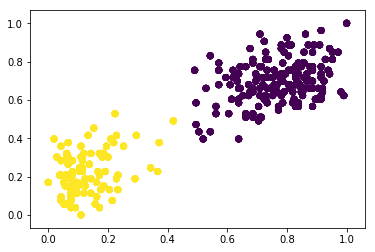

In [526]:
interationNumK = []
model = GMM_EM(2, data_scaled)
for _ in range(10):
    init_mu, init_cov = runKmeans(True)
    mus, iters = model.run()
    interationNumK.append(iters)

print 'end'
runKmeans(True)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 3., 2., 1., 3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 23 Patch objects>)

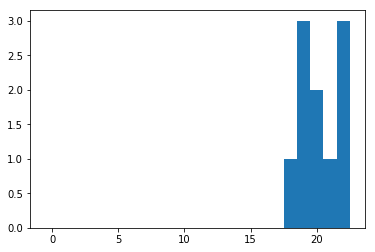

In [527]:
plt.hist(interationNumK, bins=range(max(interationNumK) + 1), align='left', rwidth=1)